In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

## Setup

In [75]:
data = pd.read_csv('files_for_lab/csv_files/marketing_customer_analysis.csv')
data.head(3)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize


In [76]:
data.shape

(9134, 24)

## Data Cleaning

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [78]:
class CustomInitialDataCleaner:
    def __init__(self, drop_features=[], date_features=[]):
        self.drop_features = drop_features
        self.date_features = date_features
    
    def __remove_duplicates(self, X):
        return X[~X.duplicated()]
    
    def __drop_features(self, X):
        return X.drop(self.drop_features, axis=1, inplace=False)
    
    def __standardize_feature_headers(self, X):
        X.columns = [col.lower().replace(' ', '_') for col in X.columns]
        return X
    
    def __handle_dates(self, X):
        for date_f in self.date_features:
            date_feature = pd.to_datetime(X[date_f])
            X[f'{date_f}_year'] = date_feature.dt.year
            X[f'{date_f}_month'] = date_feature.dt.month
            X[f'{date_f}_day'] = date_feature.dt.day
            X.drop(date_f, axis=1, inplace=True)
            return X
        
    def clean(self, X):
        X = self.__remove_duplicates(X)
        X = self.__drop_features(X)
        X = self.__handle_dates(X)
        return self.__standardize_feature_headers(X)

In [79]:
custom_cleaner = CustomInitialDataCleaner(drop_features=['Customer'], \
                                          date_features=['Effective To Date'])
df = custom_cleaner.clean(data)
df.head(2)

,state,customer_lifetime_value,response,coverage,education,employmentstatus,gender,income,location_code,marital_status,...,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,effective_to_date_year,effective_to_date_month,effective_to_date_day
0,Washington,2763.519279,No,Basic,Bachelor,Employed,F,56274,Suburban,Married,...,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,2011,2,24
1,Arizona,6979.535903,No,Extended,Bachelor,Unemployed,F,0,Suburban,Single,...,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,2011,1,31


In [80]:
# only one static value here
df['effective_to_date_year'].unique()

array([2011])

In [81]:
df.drop('effective_to_date_year', axis=1, inplace=True)

In [82]:
df.isna().sum()

state                            0
customer_lifetime_value          0
response                         0
coverage                         0
education                        0
employmentstatus                 0
gender                           0
income                           0
location_code                    0
marital_status                   0
monthly_premium_auto             0
months_since_last_claim          0
months_since_policy_inception    0
number_of_open_complaints        0
number_of_policies               0
policy_type                      0
policy                           0
renew_offer_type                 0
sales_channel                    0
total_claim_amount               0
vehicle_class                    0
vehicle_size                     0
effective_to_date_month          0
effective_to_date_day            0
dtype: int64

## EDA

Check numerical features

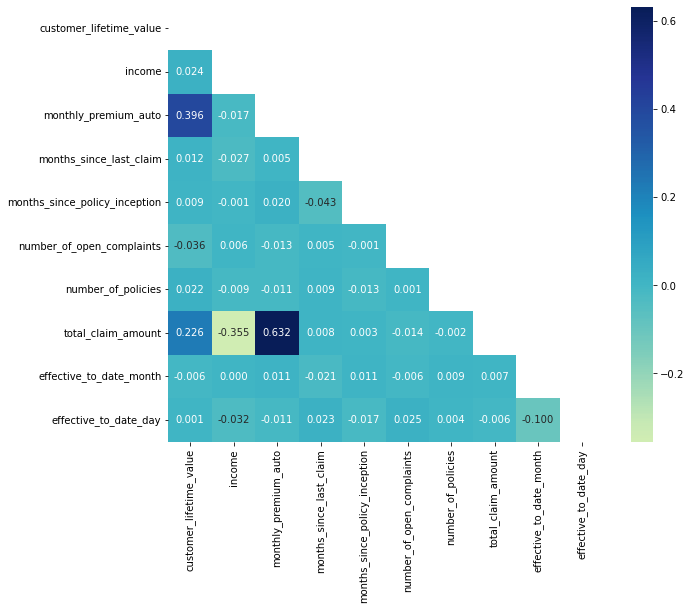

In [83]:
# correlation matrix for numerical cols
num_corr = df.select_dtypes('number').corr()
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(num_corr, center=0, fmt=".3f", square=True, annot=True, mask=mask, cmap="YlGnBu")
plt.show()

In [84]:
# Check for correlation between total claim amont and the numerical cols
df.select_dtypes('number').corr()['total_claim_amount'].sort_values(ascending=False)

total_claim_amount               1.000000
monthly_premium_auto             0.632017
customer_lifetime_value          0.226451
months_since_last_claim          0.007563
effective_to_date_month          0.006820
months_since_policy_inception    0.003335
number_of_policies              -0.002354
effective_to_date_day           -0.005707
number_of_open_complaints       -0.014241
income                          -0.355254
Name: total_claim_amount, dtype: float64

In [85]:
# helper func to get set of features above certain threshold
def correlation_check(df, threshold):
    corr_matrix = df.select_dtypes('number').corr()
    c_sorted = corr_matrix.unstack().sort_values()
    threshold_pairs = c_sorted[(abs(c_sorted) > threshold) & (abs(c_sorted) < 1)]
    
    return set(threshold_pairs.index.get_level_values(0))

In [86]:
strong_corr_features = correlation_check(df, 0.3)
strong_corr_features

{'customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'total_claim_amount'}

### Plot the stronger correlated features (to target)

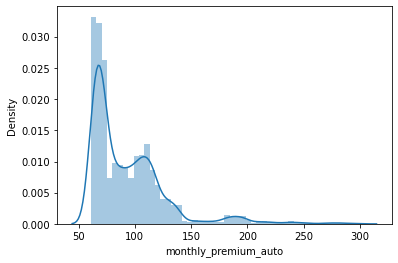

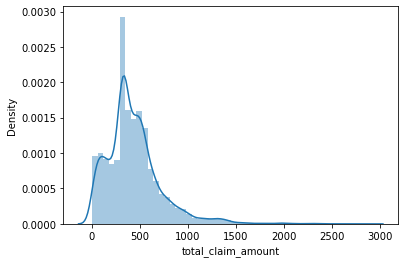

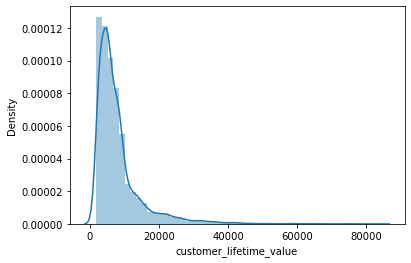

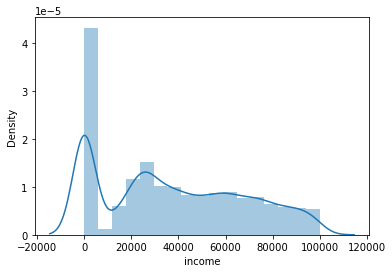

In [87]:
# plot features with abs corr > 0.3
for col in df[list(strong_corr_features)]:
    sns.distplot(df[col])
    plt.show()

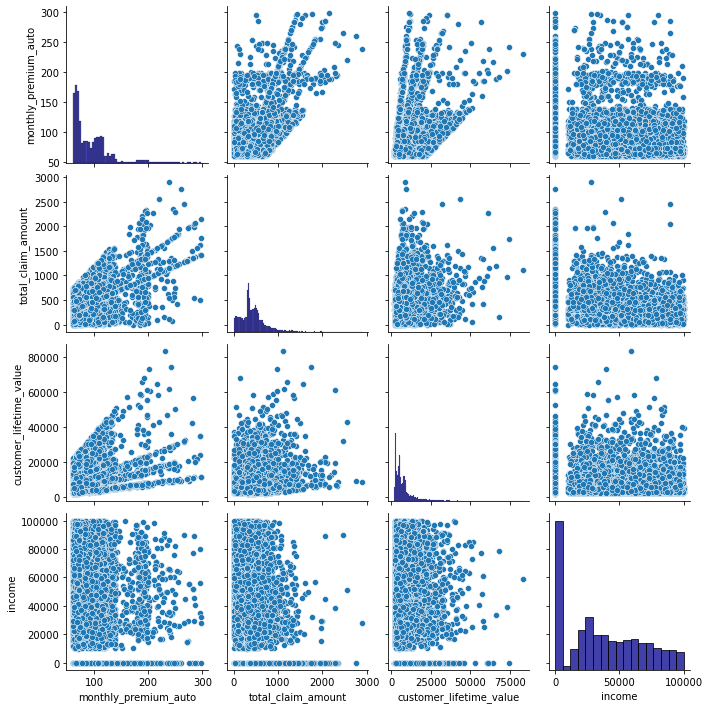

In [88]:
# pair plot features with abs corr > 0.3
sns.pairplot(df[list(strong_corr_features)], diag_kws={'color':'darkblue'})

### Plot categorical features

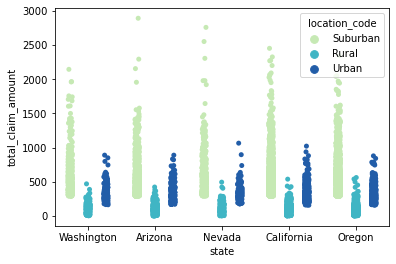

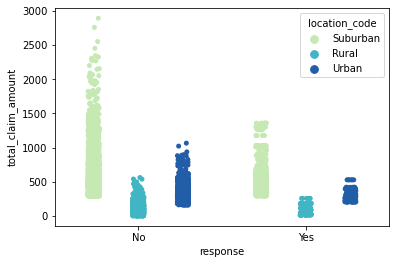

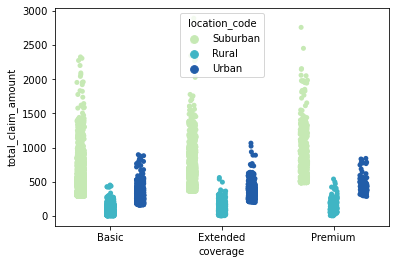

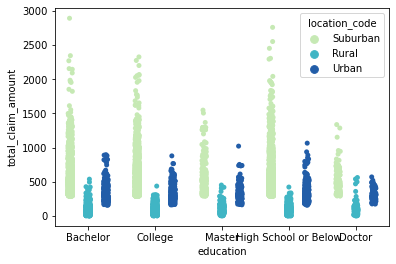

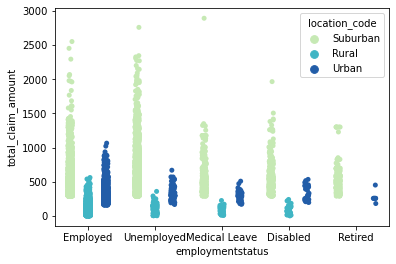

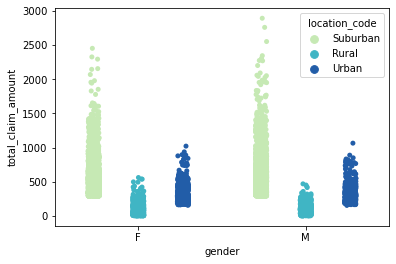

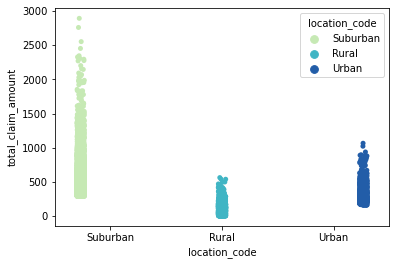

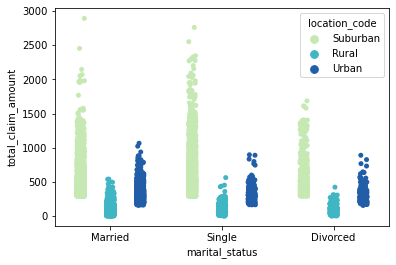

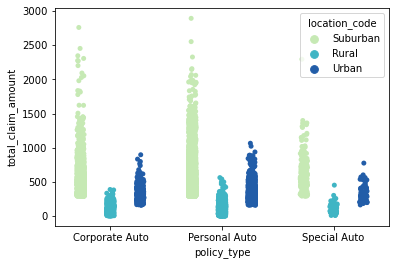

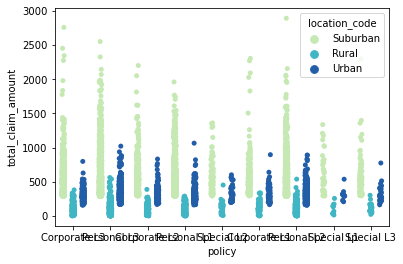

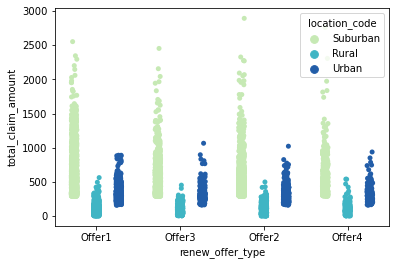

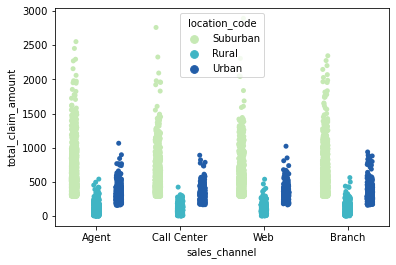

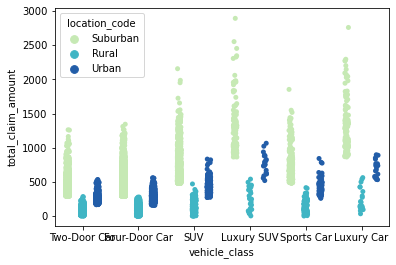

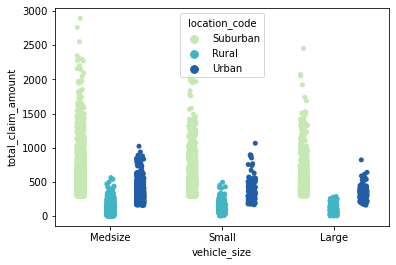

In [89]:
for col in df.select_dtypes('object'):
    sns.stripplot(x=col, y="total_claim_amount", data=df, hue="location_code", \
                  palette="YlGnBu", dodge=True)
    plt.show()

## Data Preprocessing

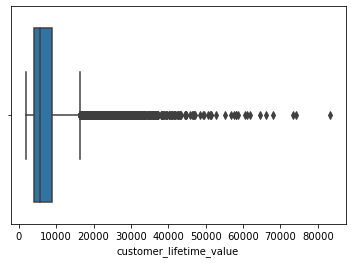

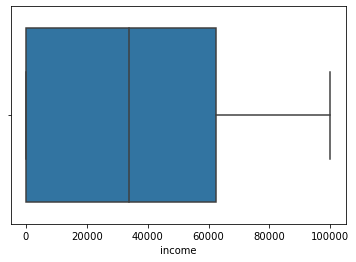

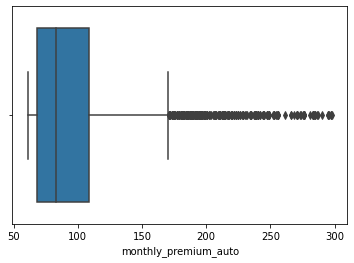

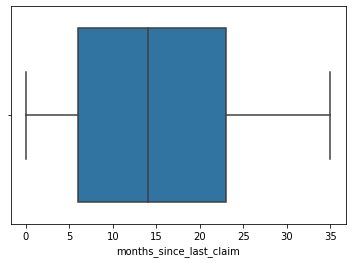

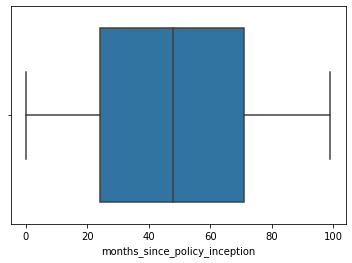

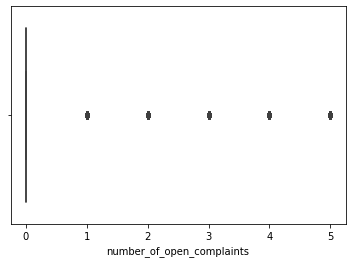

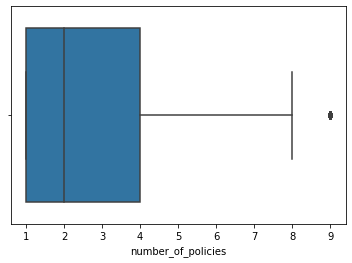

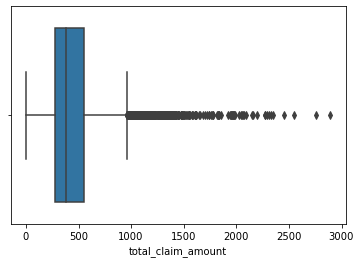

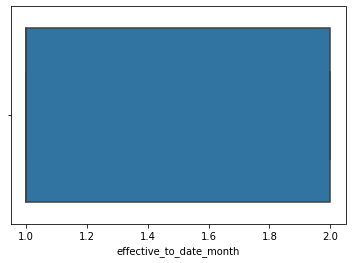

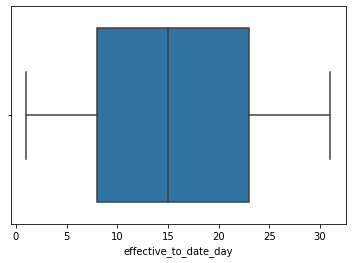

In [90]:
for col in df.select_dtypes('number'):
    sns.boxplot(df[col])
    plt.show()

In [91]:
print(f'outliers total claim amount > 2300: {df[df["total_claim_amount"] > 2300].shape[0]}')
print(f'outliers customer lifetime value > 65.000: {df[df["customer_lifetime_value"] > 65_000].shape[0]}')

outliers total claim amount > 2300: 7
outliers customer lifetime value > 65.000: 5


In [95]:
# drop the outliers since very few in count
out_1 = df[df["customer_lifetime_value"] > 65_000].index
out_2 = df[df["total_claim_amount"] > 2300].index

df.drop(out_1, axis=0, inplace=True)
df.drop(out_2, axis=0, inplace=True)
df.shape

(9122, 24)

In [96]:
X = df.drop('total_claim_amount', axis=1)
y = df['total_claim_amount']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [104]:
lin_reg_pipe = Pipeline([
    ('scaling', ColumnTransformer([
        ('numerical', StandardScaler(), X.select_dtypes('number').columns),
        ('categorical', OneHotEncoder(), X.select_dtypes('object').columns)])),
    ('model', LinearRegression())
])

## Model fitting and results

In [106]:
lin_reg_pipe.fit(X_train, y_train);

In [117]:
y_pred = lin_reg_pipe.predict(X_test)

In [113]:
# metrics
r2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
MSE = mean_squared_error(y_test, y_pred, squared=True)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print
print(f'R2: {r2} \nMAE: {MAE} \nRMSE: {RMSE} \nMSE: {MSE} \nMAPE: {MAPE}')

R2: 0.7608336965709122 
MAE: 94.60526410394593 
RMSE: 131.7683002920345 
MSE: 17362.884961851778 
MAPE: 0.602254623929384


<AxesSubplot:xlabel='total_claim_amount'>

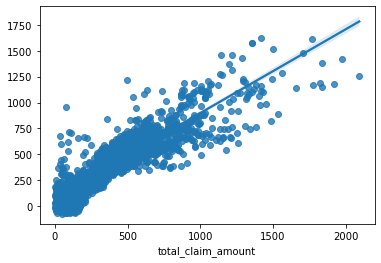

In [122]:
sns.regplot(y_test, y_pred)